<a href="https://www.kaggle.com/code/taliyameyswara/speech-accent-detection-using-cnn?scriptVersionId=210058510" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/speech-accent-archive/reading-passage.txt
/kaggle/input/speech-accent-archive/speakers_all.csv
/kaggle/input/speech-accent-archive/recordings/recordings/spanish47.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/english220.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/arabic64.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/russian7.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/dutch36.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/english518.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/bengali5.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/english52.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/arabic11.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/farsi11.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/khmer7.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/french41.mp3
/kaggle/input/speech-accent-archive/r

# 🎙️🗣️ **Speech Accent Classification using CNN** 🎙️🗣️
In this project, we are going to classify speech accents from audio recordings using Convolutional Neural Networks (CNN). Classifying speech accents can be useful for things like speech recognition and language learning.

## 🎯 **Dataset Overview**
The dataset we use has audio files of people speaking with different accents. Here's an overview of the dataset:

**🎵 Audio Files:**
- Each file contains a recording of a person speaking, with a specific accent.
- All the audio files are in the .mp3 format, which is common for audio data.

🏷️ **Labels:**
- Each audio file is labeled with the accent it represents, the label is on the filename.

🛠️ **Challenges:**
- The audio files have some challenges:
  - **Noise**: Some files have background noise that makes it harder to classify the accent.
  - **Length**: The length of the audio files varies, which can affect how we process the data.
  - **Quality**: The quality of the recordings may differ, which adds complexity to the task.


## ⚙️ **Project Workflow**

This notebook will follow a step-by-step approach to solve the accent classification problem using CNN. The main steps are:

### 🗂️ 1. Loading and Exploring the Dataset:
First, we will load the audio files and take a look at the data to understand how many samples we have and what the accent distribution looks like.

### 🎛️ 2. Feature Extraction:
We cannot use raw audio data directly, so we need to extract features like Mel-frequency cepstral coefficients (MFCCs) or spectrograms from the audio files. These features will help the model better understand the audio.

### ✨ 3. Data Preprocessing:
Once we have the features, we will preprocess the data. This includes normalizing the data and making sure it's ready for training. We may also do some data augmentation to improve the model's ability to generalize.

### 🧠 4. Model Selection and Training:
Next, we will choose a CNN model and train it using the features we extracted. CNNs are good for image-like data, and audio features can be treated in a similar way to images.

### 📊 5. Evaluation and Optimization:
After training, we will evaluate how well our model performs. We will use metrics like accuracy to check how good the model is at classifying accents. If needed, we will improve the model by tuning hyperparameters and making other adjustments.


# **🚀 Project Steps Starts! 🚀**

# **🗃️ Libraries Imports**
The libraries used in the project and the steps taken to classify audio files. Each library plays a crucial role in data manipulation, feature extraction, and model building.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
import tensorflow as tf
import librosa
import os
import soundfile as sf
import torch, torchaudio
import torchaudio.functional as f
import re
from scipy.signal import resample
from sklearn.metrics import accuracy_score

# **📊 Data Loading and Initial Exploration 🧩**
We start by loading the dataset, which contains information about audio files and their corresponding classes. 📂

In [3]:
dir = '/kaggle/input/speech-accent-archive/recordings/recordings'
audio_list = os.listdir(dir)
print('Dataset length')
len(audio_list)

Dataset length


2138

In [4]:
df = pd.DataFrame()
df['speech'] = audio_list

labels = [re.sub(r'\d+\.mp3$', '', audio) for audio in audio_list]

df = pd.DataFrame({
    'speech': audio_list,
    'labels': labels
})

df.head()

,speech,labels
0,spanish47.mp3,spanish
1,english220.mp3,english
2,arabic64.mp3,arabic
3,russian7.mp3,russian
4,dutch36.mp3,dutch


## **🔍 Class Distribution 📊**

In [5]:
# count the all label
df['labels'].value_counts()

labels
english        579
spanish        162
arabic         102
mandarin        65
french          63
              ... 
baga             1
naxi             1
lamaholot        1
nama             1
mortlockese      1
Name: count, Length: 200, dtype: int64

<Axes: xlabel='labels', ylabel='count'>

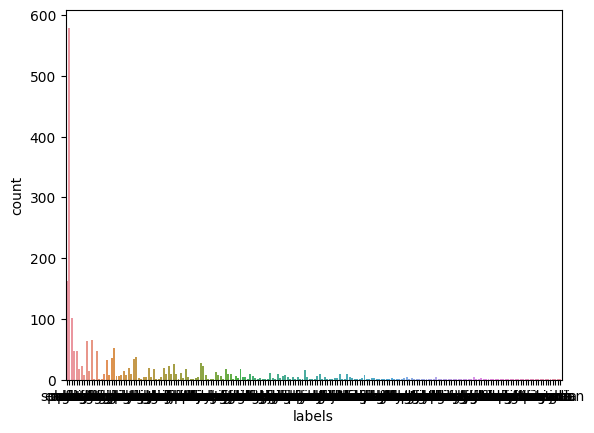

In [6]:
# data analysis of all label
sns.countplot(x = df['labels'], data=df)

As we can see, the data is imbalance. We can fix it later, after extraction

# 🎼 **Feature Extraction using MFCC** 🎶
For accurate classification, we need to extract features from the raw audio data using MFCC (Mel-frequency cepstral coefficients)

## **🔨 MFCC Feature Extraction 🔨**
We use the librosa library to extract MFCC features from each audio file. 🎵
MFCC helps capture the sound features that will be used for classification. The features are extracted, and mean values are computed for simplicity. 🧠

In [7]:
target_sample_rate = 44100  # Target sample rate for the audio

def extract_features(audio_file, n_fft=128, hop_length=32, n_mfcc=13):
    # Read the audio file using soundfile library
    y, sr = sf.read(audio_file)
    
    # Check if the sample rate is different from the target sample rate
    if sr != target_sample_rate:
        # Resample the audio to the target sample rate
        y = resample(y, int(len(y) * target_sample_rate / sr))
        sr = target_sample_rate 
        
    # Extract the first 10 seconds of audio (assuming the file is long enough)
    samples_10_sec = target_sample_rate * 5   # 10 seconds of audio at the target sample rate
    y_10_sec = y[:samples_10_sec]  # Slice the audio to get the first 10 seconds

    # Extract Mel-Frequency Cepstral Coefficients (MFCCs) from the audio
    mfccs = librosa.feature.mfcc(y = y_10_sec, sr=sr, n_mfcc=n_mfcc)
    
    # Normalize the MFCCs (mean = 0, standard deviation = 1)
    mfccs_normalized = (mfccs - np.mean(mfccs)) / np.std(mfccs)

    return mfccs  # Return the MFCC features

In [ ]:
data = []  # Empty list to store audio features and labels

# Loop through each audio file in the audio_list
for audio in audio_list:
    # Create the full path to the audio file
    audio_path = dir + "/" + audio

    # Extract features from the audio file (using the extract_features function)
    feature = extract_features(audio_path)
    
    # Create the label by removing numbers from the file name and removing the .mp3 extension
    label = re.sub(r'\d+', '', audio[:-4])  # Remove digits from the file name using regex

    # Append the feature and label as a tuple to the data list
    data.append((feature, label))


## 📊 **Converting to Dataframe** 🖼️

In [ ]:
separated_data = []  # List to store dictionaries with MFCC features for each audio
label_arr = []  # List to store the labels for each audio file

# Loop through each feature-label pair in the data
for f, l in data:
    # Create a dictionary of MFCCs by calculating the mean of each MFCC coefficient across time
    # The dictionary key is the MFCC name (e.g., 'MFCC_1', 'MFCC_2', etc.)
    mfcc_dict = {f'MFCC_{i+1}': np.mean(f[i]) for i in range(f.shape[0])}
    
    # Append the label to the label_arr list
    label_arr.append(l)
    
    # Append the dictionary of MFCCs to the separated_data list
    separated_data.append(mfcc_dict)

In [ ]:
# Convert the list of MFCC dictionaries into a Pandas DataFrame
df_new = pd.DataFrame(separated_data)

# Add the labels as a new column in the DataFrame
df_new['label'] = label_arr

# Display the first few rows of the DataFrame to check the data
df_new.head()

In [ ]:
# Check for any missing (null) values in the DataFrame and count them
df_new.isnull().sum()

In [ ]:
# Print the length of the DataFrame before removing missing values
print(len(df_new))

# Remove rows with missing (null) values from the DataFrame
df_cleaned = df_new.dropna()

# Print the length of the DataFrame after removing missing values
print(len(df_cleaned))

In [ ]:
# Get the count of each unique value (accent label) in the 'label' column
accent_counts = df_cleaned['label'].value_counts()

# Print the counts of each accent label
print(accent_counts)


# **🧹 Data Preprocessing 🧹**

## **🌈Oversampling Dataset🌈**
From the previous step, we observed that the dataset is imbalanced, meaning some accent labels appear more frequently than others. To address this issue, we can use oversampling techniques to balance the dataset by increasing the number of samples from underrepresented classes.

In [ ]:
# Find the accent label with the most samples (largest group)
largest_accent = accent_counts.idxmax()

# Get the count of the largest group (most samples)
max_count = accent_counts.max()

# Initialize an empty list to store the oversampled data
oversampled_data = []

# Loop through each accent label and its count
for accent, count in accent_counts.items():
    # If the accent is not the largest group and has more than 30 samples
    if accent != largest_accent and count > 30:
        # Get the data for the current accent
        accent_data = df_cleaned[df_cleaned['label'] == accent]
        
        # Oversample the accent group to match the size of the largest group
        oversampled_accent = accent_data.sample(n=max_count, replace=True, random_state=42)
        
        # Append the oversampled data for this accent
        oversampled_data.append(oversampled_accent)
    # If the accent is the largest group, do not oversample, just append it as is
    elif accent == largest_accent:
        oversampled_data.append(df_cleaned[df_cleaned['label'] == accent])

# Combine the oversampled data to form a new balanced DataFrame
balanced_df = pd.concat(oversampled_data)

In [ ]:
# Shuffle the rows of the balanced DataFrame to randomize the order of the samples
df_shuffled = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows of the shuffled DataFrame
df_shuffled.head()

In [ ]:
# Separate the target variable (label) into y
y = df_shuffled["label"]

# Separate the features (all columns except 'label') into x
x = df_shuffled.drop('label', axis=1)

## **🌟 Label Encoding 🌟**

To prepare the labels, we need to convert the categorical label values (accents) into numeric values. For this, we use the `LabelEncoder` from `sklearn`.

Here is how the encoding process works:

- **LabelEncoder** converts each unique label (such as an accent name) into a corresponding integer value.
- The mapping of original labels to numeric encoded values is displayed below.

**Label Mapping:**

We map the original labels to their encoded values, so that the machine learning model can interpret them correctly.


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder to encode the labels
label_encoder = LabelEncoder()

# Fit and transform the target labels (y) into encoded labels
encoded_labels = label_encoder.fit_transform(y)

# Create a dictionary to map original labels to encoded labels
label_mapping = {label: encoded_label for label, encoded_label in zip(y, encoded_labels)}

# Print the mapping of labels to encoded values
class_label = []  # Initialize an empty list to store the original labels
print("Label mapping:")
for label, encoded_label in label_mapping.items():
    class_label.append(label)  # Add original label to the list
    print(f"{label}: {encoded_label}")  # Print the original label and its corresponding encoded value


# **✂️ Splitting the Data ✂️**
We split the data into training and test sets to evaluate the model performance. 📊

80% of the data is used for training the model, and 20% is reserved for testing. 🧑‍🔬

In [ ]:
from sklearn.model_selection import train_test_split

# Convert the feature columns (excluding 'label') from the shuffled DataFrame into a NumPy array
X = np.array(df_shuffled.drop('label', axis=1).values)

# Extract the target labels ('label' column) from the shuffled DataFrame into a NumPy array
y = df_shuffled['label'].values

# Initialize the LabelEncoder to convert categorical labels into numeric values
label_encoder = LabelEncoder()

# Fit the encoder to the labels and transform the labels into numeric values (encoded labels)
y_encoded = label_encoder.fit_transform(y)

# Convert the numeric labels into one-hot encoded format (binary matrix representation)
y_onehot = to_categorical(y_encoded)

# Split the data into training and testing sets (80% for training, 20% for testing)
# The features (X) and one-hot encoded labels (y_onehot) are split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)


# **🏋️‍♂️ Model Training with CNN🎓**
Now, we fit our model to the training data.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

# Function to build the CNN model for accent classification
def build_cnn_model(input_shape):
    # Initialize the Sequential model (a linear stack of layers)
    model = Sequential()

    # Add the first 1D convolutional layer with 32 filters, a kernel size of 3, and ReLU activation function
    # input_shape is the shape of each input sample (number of features, 1 for a single channel)
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))

    # Add a MaxPooling layer with pool size of 2 to downsample the output of the previous layer
    model.add(MaxPooling1D(pool_size=2))

    # Add the second 1D convolutional layer with 64 filters and kernel size of 3, using ReLU activation
    model.add(Conv1D(64, 3, activation='relu'))

    # Add another MaxPooling layer to further downsample the feature map
    model.add(MaxPooling1D(2))

    # Flatten the 2D output from the last MaxPooling layer into a 1D vector
    model.add(Flatten())

    # Add a fully connected (Dense) layer with 128 neurons and ReLU activation function
    model.add(Dense(128, activation='relu'))

    # Add Dropout layer to reduce overfitting by randomly setting 50% of the input units to zero during training
    model.add(Dropout(0.5))

    # Add the final output layer with as many neurons as there are classes (y_train.shape[1]) and softmax activation
    # Softmax is used for multi-class classification, converting the outputs into probabilities
    model.add(Dense(y_train.shape[1], activation='softmax'))

    # Compile the model with Adam optimizer, categorical crossentropy loss function, and accuracy metric
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Return the built model
    return model

# Define the input shape for the model: (number of features, 1) for a single channel (e.g., MFCC features)
input_shape = (X_train.shape[1], 1)

# Build the CNN model using the defined input shape
model = build_cnn_model(input_shape)

# Train the model using the training data (X_train, y_train) and validate it using the test data (X_test, y_test)
# The model will train for 150 epochs with a batch size of 32, and display progress at the end of each epoch
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# **📈Plotting Accuracy & Loss📉**

In [ ]:
import matplotlib.pyplot as plt

# Get the metrics from the history object
metrics = history.history

# Create a figure with smaller subplots placed side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot Accuracy
axs[0].plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
axs[0].set_title("Accuracy CNN")
axs[0].set_ylim([0, 100])
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend(['accuracy', 'val_accuracy'])

# Plot Loss
axs[1].plot(history.epoch, np.array(metrics['loss']), np.array(metrics['val_loss']))
axs[1].set_title("Loss CNN")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend(['loss', 'val_loss'])

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Get the predicted probabilities for each class from the model
y_pred_probs = model.predict(X_test)

# Convert the predicted probabilities into class labels by selecting the index with the highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

In [ ]:
# Convert the one-hot encoded true labels (y_test) into class labels by selecting the index with the 1 in each one-hot vector
y_true = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import classification_report

# Define the list of class names corresponding to the labels
class_names = [
    "Arabic", "Dutch", "English", "French", "German", 
    "Italian", "Korean", "Mandarin", "Polish", "Portuguese", 
    "Russian", "Spanish", "Turkish"
]

# Generate the classification report, which provides metrics like precision, recall, f1-score
# for each class in the dataset
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the classification report to see the evaluation results
print(report)

In [ ]:
# Save the trained model to a file
model.save('cnn.h5')

# Load the saved model from the file
from tensorflow.keras.models import load_model
model = load_model('cnn.h5')

In [ ]:
model.save('cnn_model.keras')  # TensorFlow will use the SavedModel format by default

# **✨Hyperparameter Tuning for Improving Model Performance✨**

After training the model, the results were not satisfactory. To improve the performance, we will perform **hyperparameter tuning**. This process involves adjusting the model's hyperparameters to find the best configuration that results in better accuracy and generalization.

Hyperparameters, such as the learning rate, batch size, number of layers, and number of epochs, play a crucial role in the model's ability to learn from data and make accurate predictions. By fine-tuning these values, we aim to optimize the model's performance.

Let's start the hyperparameter tuning process to improve our model's results.

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel

# Define a class that inherits from HyperModel to enable hyperparameter tuning
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        # Initialize the model with input shape and number of classes
        self.input_shape = input_shape  # Shape of the input data (e.g., number of features in each sample)
        self.num_classes = num_classes  # Number of classes (i.e., output size)

    def build(self, hp):
        # Build the model using the provided hyperparameters (hp)
        model = Sequential()
        
        # First Convolutional Layer
        model.add(Conv1D(
            filters=hp.Int('filters1', min_value=32, max_value=128, step=32),  # Tune the number of filters
            kernel_size=hp.Int('kernel_size1', min_value=2, max_value=5, step=1),  # Tune the kernel size
            activation='relu',  # Use ReLU activation
            padding='same',  # Padding to maintain the input size
            input_shape=self.input_shape  # Input shape from the data
        ))
        model.add(MaxPooling1D(pool_size=2))  # MaxPooling to reduce the spatial size
        
        # Second Convolutional Layer
        model.add(Conv1D(
            filters=hp.Int('filters2', min_value=64, max_value=256, step=32),  # Tune the number of filters
            kernel_size=hp.Int('kernel_size2', min_value=2, max_value=5, step=1),  # Tune the kernel size
            activation='relu',  # Use ReLU activation
            padding='same'  # Padding to maintain the input size
        ))
        model.add(MaxPooling1D(pool_size=2))  # MaxPooling to reduce the spatial size
        
        # Flatten the output of the convolutional layers to feed into fully connected layers
        model.add(Flatten())

        # Fully connected layer (Dense Layer)
        model.add(Dense(
            hp.Int('dense_units', min_value=64, max_value=256, step=64),  # Tune the number of units in the dense layer
            activation='relu'  # Use ReLU activation for the dense layer
        ))

        # Dropout layer to prevent overfitting (randomly drops some of the units during training)
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))  # Tune the dropout rate

        # Output layer with softmax activation (for multi-class classification)
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model with Adam optimizer and categorical crossentropy loss function
        model.compile(
            optimizer=Adam(
                hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')  # Tune the learning rate with log sampling
            ),
            loss='categorical_crossentropy',  # Suitable loss function for multi-class classification
            metrics=['accuracy']  # Track accuracy during training
        )
        
        # Return the compiled model
        return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# EarlyStopping callback stops training when the model stops improving
early_stopper = EarlyStopping(
    monitor='val_loss',  # Monitors the validation loss to check for improvement
    patience=10,  # Number of epochs to wait for improvement before stopping
    verbose=1,  # Prints a message when the training is stopped early
    restore_best_weights=True  # Restores the weights from the epoch with the best validation loss
)

# ReduceLROnPlateau callback reduces the learning rate when the model stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitors the validation loss to check for improvement
    factor=0.5,  # Multiplies the current learning rate by this factor (0.5) when the loss plateaus
    patience=5,  # Number of epochs to wait before reducing the learning rate
    verbose=1,  # Prints a message when the learning rate is reduced
    min_lr=1e-6  # Minimum learning rate the optimizer can reach, prevents it from going too low
)

In [ ]:
from kerastuner.tuners import RandomSearch

input_shape = (X_train.shape[1], 1) 
num_classes = y_train.shape[1] 

hypermodel = CNNHyperModel(input_shape=input_shape, num_classes=num_classes)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='model_tuning',
    project_name='AccentClassification'
)

tuner.search(x=X_train, y=y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopper, reduce_lr])

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, y_test)
print("Best model accuracy: {:.2f}%".format(accuracy * 100))

In [ ]:
# Creating CNN model with the optimized parameter from the start
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv1D(filters=32, kernel_size=4, activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.0011876), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

best_model = create_cnn_model(input_shape, num_classes)

# Train data again from the start
history = best_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), verbose=2)

In [ ]:
import matplotlib.pyplot as plt

# Get the metrics from the history object
metrics = history.history

# Create a figure with smaller subplots placed side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot Accuracy
axs[0].plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
axs[0].set_title("Accuracy CNN")
axs[0].set_ylim([0, 100])
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend(['accuracy', 'val_accuracy'])

# Plot Loss
axs[1].plot(history.epoch, np.array(metrics['loss']), np.array(metrics['val_loss']))
axs[1].set_title("Loss CNN")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend(['loss', 'val_loss'])

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Predict the probabilities for each class
y_pred_probs = best_model.predict(X_test)
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import classification_report

class_names = [
    "Arabic", "Dutch", "English", "French", "German", 
    "Italian", "Korean", "Mandarin", "Polish", "Portuguese", 
    "Russian", "Spanish", "Turkish"
]

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

In [ ]:
# Save the model
best_model.save('cnn_tunning.h5') 
loaded_model = load_model('cnn_tunning.h5') 
loss, accuracy = loaded_model.evaluate(X_test, y_test)
print("Loaded model accuracy:", accuracy)

In [ ]:
best_model.save('cnn_tunning_keras.keras') 

In [ ]:
from tensorflow.keras.models import load_model

# Load the best model you saved earlier
model = load_model('/kaggle/working/cnn_tunning.h5')

In [ ]:
def preprocess_audio(file_path, target_sample_rate=44100, n_mfcc=13):
    # Load data
    y, sr = librosa.load(file_path, sr=target_sample_rate)
    
    # Extract MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # Normalize MFCC
    mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
    mfcc = mfcc.T
    
    # Get 13 MFCC coefficients
    if mfcc.shape[0] > 13:
        mfcc = mfcc[:13, :]
    else:
        # Padd with zeros if coefficients are less than 13
        mfcc = np.pad(mfcc, ((0, 13 - mfcc.shape[0]), (0, 0)), mode='constant')
    mfcc = np.mean(mfcc, axis=1, keepdims=True)
    
    # Expand dimensions to match the input shape of the model (batch_size, time_steps, features)
    mfcc = np.expand_dims(mfcc, axis=0)
    
    return mfcc

In [ ]:
file_path = '/kaggle/input/speech-accent-archive/recordings/recordings/arabic14.mp3'

# Preprocess the audio
audio_data = preprocess_audio(file_path)
print("Shape of preprocessed audio data:", audio_data.shape) 

In [ ]:
predictions = model.predict(audio_data)

predicted_class = np.argmax(predictions, axis=1)

class_names = [
    "Arabic", "Dutch", "English", "French", "German", 
    "Italian", "Korean", "Mandarin", "Polish", "Portuguese", 
    "Russian", "Spanish", "Turkish"
]

print(f"The predicted class for the audio file is: {class_names[predicted_class[0]]}")

In [ ]:
model.save('cnn_tunning.h5')

In [ ]:
import tensorflow as tf
from joblib import load

def load_model(model_name):
    if model_name.endswith('.h5'):
        model = tf.keras.models.load_model(model_name)
    else:
        model = load(f'{model_name}.joblib')
    return model

load_model('/kaggle/working/cnn_tunning.h5')